<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/zindi_airstrip_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [ ]:
%%capture
!pip -q install geopandas
!pip -q install geojson
!pip -q install rasterio
!pip -q install tqdm
!pip -q install segmentation-models-pytorch
!pip -q install albumentations
!pip -q install gdown

In [ ]:
# Standard imports
import os
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box
from rasterio.io import MemoryFile
from rasterio.transform import from_bounds

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl

# Deep learning libraries
import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utility libraries
import glob
import re
import shutil
import gdown

## Create folder to store data products in Colab Runtime
Create a `working` folder in Google Colab runtime for storing intermediate data products. This folder is deleted at the end of your session.

In [ ]:
# Define the path for the new folder
working_path = '/content/working'

# Create the folder if it doesn't already exist
if not os.path.exists(working_path):
    os.makedirs(working_path)
    print(f"Folder created: {working_path}")
else:
    print(f"Folder already exists: {working_path}")

Folder created: /content/working


# Download data to local compute node

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download inference images from your Google Drive

**Note:** If you are working with your own data, edit the path to your inference images in the cell below

In [ ]:
# Navigate to the directory with inference images
%cd /content/drive/MyDrive/P2 - Amazon ITU - PESU/Training Images/Sentinel_inference
# Zip the data
!zip -r /content/Sentinel_inference.zip .
# Unzip the files
!unzip /content/Sentinel_inference.zip -d /content/Sentinel_inference

/content/drive/.shortcut-targets-by-id/1-DbkyCW1BaeQ_nKLgfuH-kj036N57maK/Sentinel_inference
  adding: Sentinel_AllBands_Inference_2020_03.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2020_02.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2020_01.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2021_02.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2021_01.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2021_04.tif (deflated 4%)
  adding: Sentinel_AllBands_Inference_2021_03.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2022_01.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2022_02.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2024_01.tif (deflated 5%)
  adding: Sentinel_AllBands_Inference_2023_01.tif (deflated 5%)
Archive:  /content/Sentinel_inference.zip
  inflating: /content/Sentinel_inference/Sentinel_AllBands_Inference_2020_03.tif  
  inflating: /content/Sentinel_inference/Sentinel_AllBands_Inference_2020_02.ti

## Download inference images from Team TerraPulse's Google Drive

**Note**: If you want to work with inference images generated by team TerraPulse, uncomment the 2 cells below.

In [ ]:
# # ID of a zip archive in Team TerraPulse's Google Drive
# file_id = "1HbfE0BFF9CVukUlhl6hUKlujPtAth7BU"
# url = f"https://drive.google.com/uc?id={file_id}"

# # Download zip archive
# gdown.download(url, "inference.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1HbfE0BFF9CVukUlhl6hUKlujPtAth7BU
From (redirected): https://drive.google.com/uc?id=1HbfE0BFF9CVukUlhl6hUKlujPtAth7BU&confirm=t&uuid=6ba889f6-f420-4820-83c4-fab96ed3ac83
To: /content/drive/.shortcut-targets-by-id/1-DbkyCW1BaeQ_nKLgfuH-kj036N57maK/Sentinel_inference/inference.zip
 17%|█▋        | 201M/1.19G [00:03<00:19, 50.7MB/s]

In [ ]:
# # Unzip archive
# !unzip inference.zip -d /content

Archive:  inference.zip
  inflating: /content/inference/Sentinel_AllBands_Inference_2022_01.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2020_03.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2021_04.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2020_01.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2021_01.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2021_03.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2023_01.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2022_02.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2024_01.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2021_02.tif  
  inflating: /content/inference/Sentinel_AllBands_Inference_2020_02.tif  


## Get list of AOIs


AOI's are stored in team TerraPulse's GitHub repo (`zindi-amazon-secret-runway`). The following cell creates a new folder `zindi-amazon-secret-runway` in Google Colab runtime. Shapefiles for the individual AOI's are located in this folder.

In [ ]:
# Navigate back to /content
%cd /content

# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'zindi-amazon-secret-runway'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 510 (delta 72), reused 39 (delta 35), pack-reused 388 (from 1)
Receiving objects: 100% (510/510), 64.14 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (240/240), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'

In [ ]:
aoi_list = []

In [ ]:
# Get a list of all shapefiles in the folder
shapefiles = glob.glob(f'{base_aoi_path}/*.shp')

# Extract `year_month` from each file path
for shp in shapefiles:
    match = re.search(r'(\d{4}_\d{2})', shp)  # Looks for pattern like 2021_04
    if match:
        aoi_list.append(match.group(1))

print(f"Total number of AOIs: {len(aoi_list)}")
print('\n'.join([f"{index}: {item}" for index, item in enumerate(aoi_list)]))

Total number of AOIs: 11
0: 2022_01
1: 2020_02
2: 2021_04
3: 2021_03
4: 2022_02
5: 2020_03
6: 2024_01
7: 2021_02
8: 2020_01
9: 2021_01
10: 2023_01


## Download model from your Google Drive

**Note**: If you are working with your own data, edit the path to your model in the cell below

In [ ]:
# model_name = "zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV"

# # Specify the file path of your model
# model_path = f"/content/drive/MyDrive/Zindi-Amazon/models/{model_name}.pth"

# # Move the file to the root directory of Colab
# shutil.copy(model_path, f"/content/{model_name}.pth")

'/content/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth'

## Download model from Team TerraPulse's Google Drive

**Note**: If you want to work with model file generated by team TerraPulse, uncomment the cell below

In [ ]:
# Model file name - Zindi-Amazon/models/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth
# Link to model file - https://drive.google.com/file/d/1-IbCXlVxmwLTLg7utU2E7A2uYB0D80A_/view?usp=drive_link

# Extracted file id from link to model file
file_id = "1-IbCXlVxmwLTLg7utU2E7A2uYB0D80A_"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

gdown.download(url, "zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-IbCXlVxmwLTLg7utU2E7A2uYB0D80A_
From (redirected): https://drive.google.com/uc?export=download&id=1-IbCXlVxmwLTLg7utU2E7A2uYB0D80A_&confirm=t&uuid=e5b4694f-029b-4673-a28c-eb2469e3b812
To: /content/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth

  0%|          | 0.00/130M [00:00<?, ?B/s]
  4%|▎         | 4.72M/130M [00:00<00:07, 15.9MB/s]
  8%|▊         | 11.0M/130M [00:00<00:04, 27.9MB/s]
 17%|█▋        | 22.5M/130M [00:00<00:02, 53.3MB/s]
 23%|██▎       | 29.9M/130M [00:00<00:01, 57.7MB/s]
 29%|██▊       | 37.2M/130M [00:00<00:01, 47.9MB/s]
 34%|███▍      | 44.6M/130M [00:00<00:01, 53.9MB/s]
 43%|████▎     | 56.1M/130M [00:01<00:01, 69.5MB/s]
 49%|████▉     | 64.5M/130M [00:01<00:01, 40.4MB/s]
 61%|██████    | 79.2M/130M [00:01<00:00, 58.7MB/s]
 68%|██████▊   | 88.1M/130M [00:01<00:00, 54.2MB/s]
 74%|███████▎  | 95.9M/130M [00:01<00:00, 56.6MB/s]
 79%|███████▉  | 103M/130M [00:02<00:00, 40.2MB/s]

'zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth'

# Functions to run inference on satellite image for an aoi for selected model

## Define and load model

We used B4, B3 and B2 bands from Sentinel 2 satellite images as default for all models we ran. For some models, NIR (Sentinel 2) and VV (Sentinel 1) bands were included in the model.

In [ ]:
# UNet model with ResNet50 encoder
def get_model(channels):
    model = smp.Unet(
        encoder_name='resnet50', # Choose encoder
        encoder_weights='imagenet', # Use pre-trained weights
        in_channels=channels,
        classes=1, # Binary segmentation
    )
    return model

def load_model(model_file, additional_bands):
    """
    Loads a pre-trained model for inference, configuring it for the specified number of input channels based on default and additional bands.

    Parameters:
    - model_name (str): The name of the model file to load. The function expects the model file to be stored at the specified `shared_path`.
    - additional_bands (list of str): A list of additional band names (e.g., "B8", "VV") to include as input channels, in addition to the default RGB bands (B4, B3, B2).

    Returns:
    - model (torch.nn.Module): The loaded PyTorch model, set to evaluation mode and moved to the appropriate device (GPU or CPU).

    Process:
    1. Sets the computation device to GPU if available, otherwise defaults to CPU.
    2. Calculates the total number of input channels required by the model, based on the default RGB bands and any additional bands provided.
    3. Loads the specified pre-trained model and transfers it to the selected device.
    4. Configures the model to evaluation mode and checks the model's input channel configuration, printing details to confirm compatibility.
    5. Returns the loaded model for inference.

    Example:
    ```
    model = load_model("resnet50", additional_bands=["B8", "VV"])
    ```
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Calculate total number of channels
    defualt_bands = ['B4', 'B3', 'B2']
    channels = len(defualt_bands) + len(additional_bands)

    model = get_model(channels).to(device)
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()

    print('Model file {} successfully loaded.'.format(model_name))

    # Check the number of input channels in the model
    input_channels = model.encoder.conv1.in_channels
    print(f"The model expects {input_channels} input channels.")

    return model

## Load AOI boundary

In [ ]:
def get_aoi_boundary(aoi_name):
    """
    Loads the boundary of a specified Area of Interest (AOI) from a shapefile and retrieves its coordinate reference system (CRS).

    Parameters:
    - aoi_name (str): The identifier for the AOI, used to locate the corresponding shapefile.

    Returns:
    - aoiboundary (GeoDataFrame): A GeoDataFrame containing the boundary geometry of the specified AOI.
    - aoicrs (str): The coordinate reference system (CRS) of the AOI boundary.

    Process:
    1. Constructs the file path to the shapefile using the provided AOI name.
    2. Reads the shapefile into a GeoDataFrame, which includes the AOI boundary geometry.
    3. Extracts the CRS of the AOI boundary for reference in further geospatial operations.

    Example:
    ```
    aoiboundary, aoicrs = get_aoi_boundary('2021_01')
    ```

    Raises:
    - FileNotFoundError: If the specified AOI shapefile does not exist at the constructed path.
    """

    shapefile = os.path.join(base_aoi_path, f'aoi_{aoi_name}.shp')
    aoiboundary = gpd.read_file(shapefile )
    aoicrs = aoiboundary.crs
    return aoiboundary, aoicrs

## Download inference image for AOI and select the bands

The satellite images used for inference have 9 bands from both Sentinel 1 and Sentinel 2. This function fetches the satellite image for an AOI using the Rasterio library from a shared folder in Google Drive. It creates a new image with a subset of the bands depending on the model and saves it in the `working` folder

In [ ]:
def get_inference_image(aoi, transform=None, additional_bands=[]):
    """
    Extracts specific bands from a Sentinel satellite image, rescales RGB bands, and saves a subset of the bands
    to a new GeoTIFF file.

    Parameters:
    - aoi (str): The area of interest identifier, used to locate the specific image file.
    - transform (optional): Placeholder parameter for any future transformation functionality.
    - additional_bands (list of str, optional): List of additional band names (e.g., "B8", "VV") to include in the output image
      along with the RGB bands (B4, B3, B2). Default is an empty list.

    Returns:
    - output_file (str): The path to the newly created TIFF file containing the selected bands.

    Process:
    1. Constructs the image file path for the specified AOI.
    2. Opens the image and retrieves the specified bands (B4, B3, B2, plus any additional bands).
    3. Validates that all required bands are present in the source image.
    4. Rescales the RGB bands (B4, B3, B2) to a range of [0, 1] by clipping values to 2000 and normalizing.
    5. Stacks additional bands (if provided) with the RGB bands to create a multi-band array.
    6. Writes the resulting array to a new TIFF file with updated metadata for the specified bands.
    7. Saves the file in the specified directory and returns the file path.
    """


    image_path = os.path.join('/content/Sentinel_inference/', 'Sentinel_AllBands_Inference_{}.tif'.format(aoi))

    with rasterio.open(image_path) as src:

        # Initialize dictionary for all required bands
        bands = {desc: src.read(i + 1) for i, desc in enumerate(src.descriptions) if desc in ['B4', 'B3', 'B2'] + additional_bands}

        # Ensure all specified bands are present
        required_bands = ['B4', 'B3', 'B2'] + additional_bands
        for band in required_bands:
            if band not in bands:
                raise ValueError(f"Missing band {band} in image: {image_path}")

        # Update metadata for the new file
        out_meta = src.meta.copy()
        out_meta.update({
            "count": len(required_bands)  # Number of bands to save in the new file
        })

        # Rescale RGB bands (B4, B3, B2) only
        rgb_image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
        rgb_image = np.clip(rgb_image, 0, 2000) / 2000  # Scaling between 0 and 1

        # Stack additional bands without normalization
        other_band_images = [bands[band] for band in additional_bands]
        if other_band_images:
            full_image = np.concatenate([rgb_image] + [np.expand_dims(b, axis=-1) for b in other_band_images], axis=-1)
        else:
            full_image = rgb_image

        band_data = np.moveaxis(full_image, -1, 0)  # Reorder to (bands, height, width)

        # Output file
        output_file = os.path.join(working_path, 'Sentinel_AllBands_Inference_{}_subset.tif'.format(aoi_name))

        # Write the subset of bands to a new TIFF file
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(band_data)
            print(f"New TIFF file with selected bands created at: {output_file}")

    return output_file

## Generate tiles for inference image

During training, the model learned to recognize patterns within a specific patch size. The inference image is split up into same sized patches before running inference. This function creates geosjon file containing tiles for an AOI and saves it in the `working` folder.

In [ ]:
# Define patch size
patch_size = 224

In [ ]:
def generate_tiles(image_file, output_file, aoi_name, size=224):
    """
    Generates a grid of square polygon tiles of a specified size from a georeferenced raster image and saves them as a GeoJSON file.

    Args:
      image_file (str): Path to the input raster image file (e.g., .tif format).
      output_file (str): Path to save the output GeoJSON file containing the generated tiles.
      aoi_name (str): Name of the Area of Interest (AOI), used in naming the output file.
      size (int, optional): Size of each square tile in pixels (default is 224).

    Returns:
      GeoDataFrame: A GeoDataFrame containing a grid square polygon tiles.

    Process:
    1. Opens the input raster image and retrieves its dimensions.
    2. Creates a sliding window over the image dimensions to define square tiles of the specified size.
    3. For each tile, calculates its georeferenced bounding box and generates a corresponding polygon.
    4. Assigns a unique ID to each tile polygon and stores it in a dictionary.
    5. Converts the dictionary to a GeoDataFrame, sets its coordinate reference system (CRS), and saves it as a GeoJSON file.
    6. Closes the raster file and returns the resulting GeoDataFrame.

    Example:
    ```
    tiles_gdf = generate_tiles("input_image.tif", "output_tiles.geojson", "2020_01", size=224)
    ```
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 224 x 224 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(aoi_name.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to AOI crs
    results.crs = {'init' : aoicrs}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")
    print(f"Tiles saved to: {output_file}")

    raster.close()
    return results

## Define data transformations

A set of data transformations to the test set were applied during training. Before running the inference images through the model, these same transformations are applied to the inference image.

In [ ]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='inference', optional_bands=None):
    """
    Creates an augmentation pipeline for satellite images using Albumentations, with optional normalization for additional bands.

    Parameters:
    - option (str): The phase of the augmentation, which determines the transformations applied.
                    Must be one of 'train', 'val', 'test', or 'inference'.
    - optional_bands (list of str, optional): List of additional band names (e.g., "B8", "B11") to include in normalization
                                              beyond the default RGB bands (B4, B3, B2). Defaults to None.

    Returns:
    - A.Compose: An Albumentations composition of transformations to be applied to the images.

    Process:
    1. Defines the mean and standard deviation for RGB bands and additional optional bands for normalization.
    2. Combines the base and optional band statistics as needed to compute the mean and standard deviation.
    3. Based on the specified `option` (e.g., 'train', 'val'), sets up an augmentation pipeline with transformations such as cropping, flipping, and rotation.
    4. Adds normalization using the computed mean and standard deviation and converts images to tensors.
    5. Returns the composed augmentation pipeline ready to be applied to satellite imagery.

    Example:
    ```
    augmentations = get_augmentations(option='inference', optional_bands=['B8', 'VV'])
    ```
    """

    # Define mean and std for RGB (B4, B3, B2)
    base_band_means = {'B4': 0.485, 'B3': 0.456, 'B2': 0.406}
    base_band_stds = {'B4': 0.229, 'B3': 0.224, 'B2': 0.225}

    # Define mean and std for additional optional bands
    optional_band_means = {'B8': 2987.760, 'B11': 1656.303, 'B12': 729.068, 'VV': -8.048, 'VH': -14.456, 'VV_VH_Ratio': 0.547}
    optional_band_stds = {'B8': 504.165, 'B11': 314.123, 'B12': 203.183, 'VV': 1.911, 'VH': 1.825, 'VV_VH_Ratio': 0.064}

    # Combine base bands and optional bands
    all_band_means = {**base_band_means, **optional_band_means}
    all_band_stds = {**base_band_stds, **optional_band_stds}

    # If optional_bands is specified, get only those; otherwise, default to RGB
    selected_bands = ['B4', 'B3', 'B2'] + (optional_bands if optional_bands else [])
    mean = tuple(all_band_means[band] for band in selected_bands)
    std = tuple(all_band_stds[band] for band in selected_bands)

    # # Define augmentation pipeline based on phase
    augmentations = {
        'train': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ],
        'val': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'test': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'inference': [
            A.CenterCrop(width=224, height=224),
        ]
    }

    if option not in augmentations:
        raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

    # Add normalization and tensor transformation
    augmentations[option].extend([
        A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
        ToTensorV2(),
    ])

    # Return the Compose pipeline
    return A.Compose(augmentations[option])

## Create a subfolder to store model outputs

In [ ]:
def create_model_folder(path, name):
    """
    Creates a new folder in the specified directory if it does not already exist, and returns the path.

    Parameters:
    - path (str): The base directory where the new folder should be created.
    - name (str): The name of the new folder to be created within the specified path.

    Returns:
    - local_folder_path (str): The full path to the newly created or existing folder.

    Example:
    ```
    folder_path = create_model_folder("/content/models", "model_xyz")
    ```
    """

    # Define the path for the new folder
    local_folder_path = path + '/' + name

    # Create the folder in colab runtine if it doesn't already exist
    if not os.path.exists(local_folder_path):
        os.makedirs(local_folder_path)
        print(f"Folder created: {local_folder_path}")
    else:
        print(f"Folder already exists: {local_folder_path}")

    return local_folder_path

## Pad image tile

In [ ]:
def pad_image_patch(image, target_size=224):
    """
    Pads an image to a specified target size with zeroes if the image dimensions are smaller than the target.

    Args:
      image (np.ndarray): The input image array in (C, H, W) format, where C is the number of channels,
                          H is the height, and W is the width.
      target_size (int, optional): The target size for both height and width. Defaults to 224.

    Returns:
      tuple:
        - padded_image (np.ndarray): The padded image array in (C, H, W) format, resized to `target_size` x `target_size`.
        - padding (tuple): The padding applied as (top, bottom, left, right) for height and width.

    Process:
    1. Calculates the necessary padding for the height and width dimensions if they are smaller than `target_size`.
    2. Pads the image symmetrically with zeroes on each side (top, bottom, left, right).
    3. If no padding is required, returns the original image.
    4. Returns the padded image along with the padding details.

    Example:
    ```
    padded_image, padding = pad_image_patch(image, target_size=224)
    ```

    Notes:
    - The padding is only applied if the height or width of the image is less than `target_size`.
    """

    channels, height, width = image.shape

    # Calculate padding for height and width
    pad_top = (target_size - height) // 2 if height < target_size else 0
    pad_bottom = target_size - height - pad_top if height < target_size else 0
    pad_left = (target_size - width) // 2 if width < target_size else 0
    pad_right = target_size - width - pad_left if width < target_size else 0

    # Apply padding only if necessary
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        padded_image = np.pad(image,
                              ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant',
                              constant_values=0)
    else:
        padded_image = image  # No padding needed

    # Return the padded image and the padding details
    return padded_image, (pad_top, pad_bottom, pad_left, pad_right)

## Run inference/prediction for each image tile

In [ ]:
def predict_airstrip(image, shape, model, optional_bands=None):
    """
    Generates model predictions for airstrip detection on a specified image tile using a trained model.

    Args:
      image (str): Path to the input image file (in .tiff format).
      shape (geometry): Polygon geometry defining the tile area to crop from the input image.
      model (torch.nn.Module): Trained PyTorch model used for prediction.
      optional_bands (list of str, optional): List of additional band names to include in the input, beyond the default bands.

    Returns:
      tuple:
        - predictions (torch.Tensor): Model's binary prediction tensor for the airstrip, where values > 0.5 are considered positive.
        - padding (tuple): The padding applied as (top, bottom, left, right) to make the cropped image match the model's input size.

    Process:
    1. Opens the input image and crops it to the specified tile shape.
    2. Pads the cropped image patch to match the model's required input size.
    3. Validates that the padded image has the correct number of bands to match the model's expected input channels.
    4. Saves the padded, cropped image as a temporary TIFF file for further processing.
    5. Loads the temporary file, applies preprocessing and transformations using the defined augmentation pipeline.
    6. Runs the processed image through the model to generate predictions.
    7. Applies a sigmoid function to the model's output to get probabilities, and thresholds the output to generate binary predictions.
    8. Returns the prediction tensor along with the padding information.

    Raises:
    - Exception: If the number of bands in the input image does not match the model's expected number of input channels.
  Example:
    ```
        predictions, padding = predict_airstrip("path/to/image.tiff", tile_geometry, model, optional_bands=["B8", "B11"])
    ```
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)

        # Pad image patch size
        padded_image, padding = pad_image_patch(out_image, patch_size)

        # Throw error if image bands dont match
        if padded_image.shape[0] != model.encoder.conv1.in_channels:
            raise Exception("Number of bands don't match")

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
            "driver": "GTiff",
            "height": padded_image.shape[1],
            "width": padded_image.shape[2],
            "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = os.path.join(working_path, 'temp.tif')
        with rio.open(temp_tif, "w", **out_meta) as dest:
            dest.write(padded_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model

        # Use rasterio to read the image instead of Pillow
        # to avoid UnidentifiedImageError(msg)
        with rio.open(temp_tif) as dataset:
            image_data = dataset.read()
            image_data = image_data.transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)

        # Get the augmentation pipeline for inference
        augmentation_pipeline = get_augmentations(option='inference', optional_bands=optional_bands)

        # Apply the transformation to the image data
        augmented = augmentation_pipeline(image=image_data)

        input = augmented['image']  # Extract the transformed image tensor

        # Move input to the same device as the model
        device = next(model.parameters()).device
        input = input.to(device)

        # Get the model's output
        output = model(input.unsqueeze(0))

        # Apply sigmoid if necessary to get probabilities between 0 and 1
        output = torch.sigmoid(output) # Uncomment if model outputs logits instead of probabilities

        # Threshold to get binary predictions (0 or 1)
        predictions = (output > 0.5).int() # Adjust threshold if needed

        # Move predictions back to CPU and convert to numpy for storage
        predictions = predictions.cpu().numpy()

        # Save prediction to .npy or .tif
        np.save(f"/content/drive/MyDrive/P2 - Amazon ITU - PESU/Training Images/Sentinel_inference", binary_mask)

        # Return the entire prediction tensor
        return (predictions, padding)

## Create a predictions raster

In [ ]:
def process_and_mosaic_predictions(tiles, inference_image_path, model_name, aoi_name, working_path):
    """
    Processes predictions for each tile in a GeoDataFrame, trims padding if applied, and mosaics all predictions into
    a single output TIFF file matching the extent and size of the original inference image.

    Args:
      tiles (GeoDataFrame): GeoDataFrame containing tile geometries, padding information, and model predictions.
      inference_image_path (str): Path to the original inference image file.
      model_name (str): Name of the model used for predictions, used in naming the output file.
      aoi_name (str): Name of the Area of Interest (AOI), used in naming the output file.
      working_path (str): Directory path to save the final mosaic TIFF file.

    Returns:
      str: Path to the saved mosaic TIFF file.

    Process:
    1. Opens the original inference image to retrieve profile metadata and determine the mosaic’s shape and extent.
    2. Initializes an empty mosaic array to accumulate predictions across all tiles.
    3. Iterates over each tile in the GeoDataFrame:
       - Extracts predictions and padding information.
       - Trims padding from the prediction array if padding was applied.
       - Computes the correct location in the mosaic for the tile based on its geometry bounds.
       - Resizes the prediction if necessary to fit into the mosaic slice.
       - Places the prediction in the appropriate mosaic location.
    4. Updates the mosaic's metadata to match the inference image and saves the result as a single-band GeoTIFF file.
    5. Visualizes the final mosaic and prints the output path.

    Example:
    ```
    output_mosaic_path = process_and_mosaic_predictions(tiles_gdf, "path/to/inference_image.tif",
                                                        model_name="model_xyz", aoi_name="2020-01",
                                                        working_path="/content/")
    ```

    Notes:
    - Padding is removed from each tile's prediction as needed before adding it to the mosaic.
    - The final mosaic file is saved in the specified working directory, organized by model and AOI name.
    """

    # Open the inference image to get its profile and dimensions
    with rio.open(inference_image_path) as src:
        profile = src.profile.copy()
        mosaic_shape = (profile['height'], profile['width'])  # Full extent size
        mosaic = np.zeros(mosaic_shape, dtype=np.uint8)  # Initialize blank mosaic

    # Process predictions for each tile
    print(f"Predicting pixel values for tiles: {aoi_name}")
    for tile_index in tqdm(range(len(tiles)), desc="Processing tiles"):
        # Retrieve the prediction from the GeoDataFrame
        predictions = tiles.iloc[tile_index]['predictions']
        # Convert predictions from torch tensor to numpy array for easier processing
        predictions_np = predictions.squeeze() if hasattr(predictions, 'squeeze') else predictions


        # Retrieve padding from the GeoDataFrame
        padding = tiles.iloc[tile_index]['padding']  # Assume padding is in (top, bottom, left, right
        # Trim padding from prediction numpy array if applied
        padding = tiles.iloc[tile_index]['padding']  # Assume padding is in (top, bottom, left, right) format
        if padding:
            pad_top, pad_bottom, pad_left, pad_right = padding
            predictions_np = predictions_np[
                pad_top: predictions_np.shape[0] - pad_bottom,
                pad_left: predictions_np.shape[1] - pad_right
            ]

        # Calculate the tile's position in the mosaic array based on its geometry bounds
        tile_geometry = tiles.iloc[tile_index]['geometry']
        minx, miny, maxx, maxy = tile_geometry.bounds
        tile_transform = from_bounds(minx, miny, maxx, maxy, predictions_np.shape[1], predictions_np.shape[0])

        # Convert the tile transform to pixel coordinates in the full mosaic
        row_start, col_start = rio.transform.rowcol(profile['transform'], minx, maxy)
        row_end, col_end = rio.transform.rowcol(profile['transform'], maxx, miny)

        # Ensure coordinates are integers and within bounds
        row_start, col_start = int(max(0, row_start)), int(max(0, col_start))
        row_end, col_end = int(min(mosaic_shape[0], row_end)), int(min(mosaic_shape[1], col_end))

        # Check if prediction is same as mosaic slice
        if (row_end - row_start, col_end - col_start) != predictions_np.shape:
          print(f"Prediction size: {predictions_np.shape}")
          print(f"Mosaic slice size: {(row_end - row_start, col_end - col_start)}")

        # Place the tile's prediction in the correct location within the mosaic array
        mosaic[row_start:row_end, col_start:col_end] = predictions_np

    # Update metadata for the mosaic to match the inference image
    profile.update({
        "driver": "GTiff",
        "count": 1  # Single band for predictions
    })

    # Save the mosaic as a GeoTIFF file on the shared drive
    output_predictions_mosaic = os.path.join(working_path, model_name, f"aoi_{aoi_name}_prediction_mosaic.tif")
    os.makedirs(os.path.dirname(output_predictions_mosaic), exist_ok=True)
    with rio.open(output_predictions_mosaic, "w", **profile) as dest:
        dest.write(mosaic, 1)

    # Visualize the mosaic
    show(mosaic, transform=profile['transform'])
    print(f"Prediction mosaic saved to: {output_predictions_mosaic}")

    return output_predictions_mosaic



In [ ]:
# Clean up working directory
!rm -rf /content/working/*

# Model inference

In [ ]:
model_name = "zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV" # Define model_name here
print(f"Selected Model: {model_name}")

Selected Model: zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV


In [ ]:
additional_bands = ['B8', 'VV']

In [ ]:
model = load_model(f'/content/{model_name}.pth', additional_bands)

Model file zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV successfully loaded.
The model expects 5 input channels.


Processing AOI: 2022_01
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2022_01_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2022_01_224x224px_patches.geojson
Make predictions for all image tiles...


/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2022_01_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2022_01


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

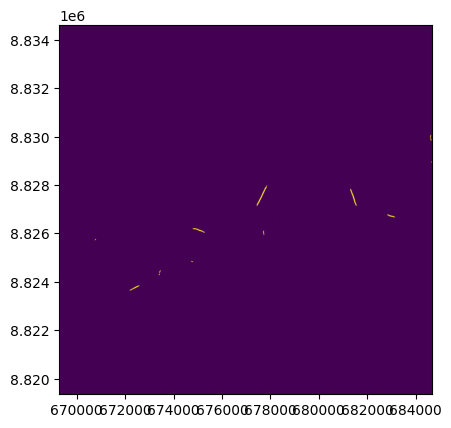

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2022_01_prediction_mosaic.tif
Finished processing AOI: 2022_01
***********************************
Processing AOI: 2020_02
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2020_02_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2020_02_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2020_02_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2020_02


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

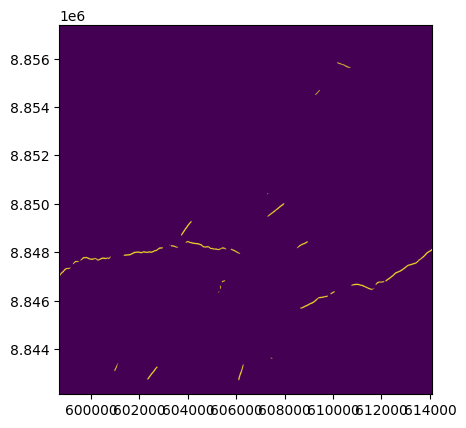

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2020_02_prediction_mosaic.tif
Finished processing AOI: 2020_02
***********************************
Processing AOI: 2021_04
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2021_04_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2021_04_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2021_04_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2021_04


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

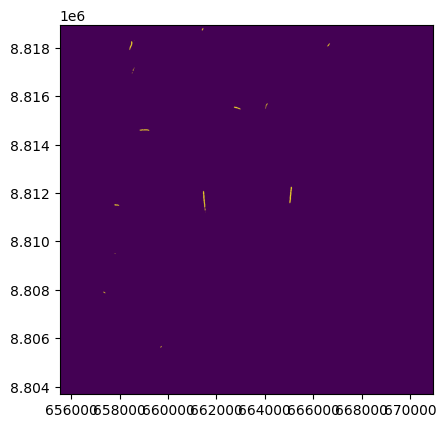

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2021_04_prediction_mosaic.tif
Finished processing AOI: 2021_04
***********************************
Processing AOI: 2021_03
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2021_03_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2021_03_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2021_03_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2021_03


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

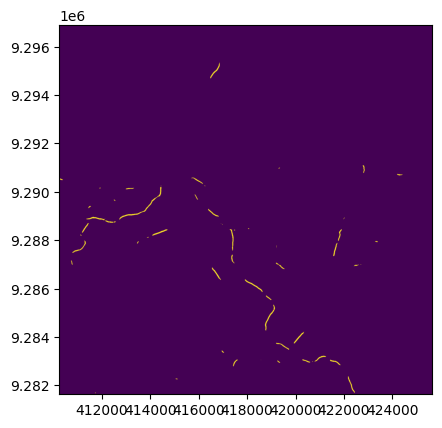

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2021_03_prediction_mosaic.tif
Finished processing AOI: 2021_03
***********************************
Processing AOI: 2022_02
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2022_02_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2022_02_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2022_02_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2022_02


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

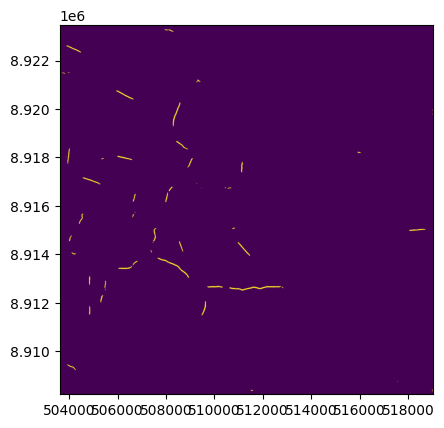

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2022_02_prediction_mosaic.tif
Finished processing AOI: 2022_02
***********************************
Processing AOI: 2020_03
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2020_03_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2020_03_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2020_03_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2020_03


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

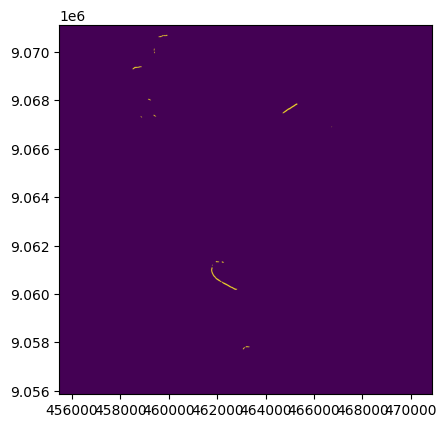

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2020_03_prediction_mosaic.tif
Finished processing AOI: 2020_03
***********************************
Processing AOI: 2024_01
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2024_01_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2024_01_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2024_01_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2024_01


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

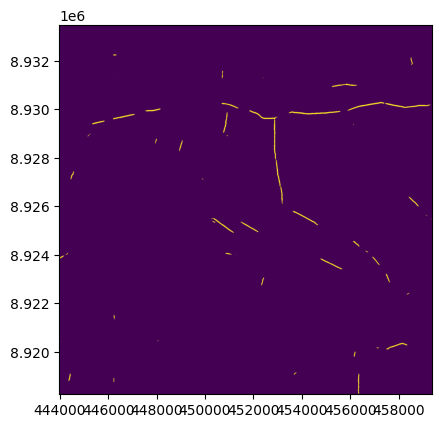

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2024_01_prediction_mosaic.tif
Finished processing AOI: 2024_01
***********************************
Processing AOI: 2021_02
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2021_02_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2350025 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2021_02_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2021_02_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2021_02


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

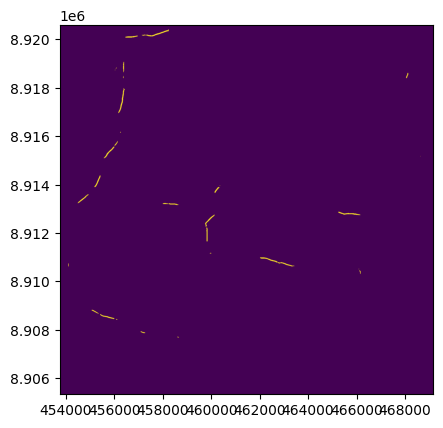

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2021_02_prediction_mosaic.tif
Finished processing AOI: 2021_02
***********************************
Processing AOI: 2020_01
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2020_01_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2020_01_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2020_01_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2020_01


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

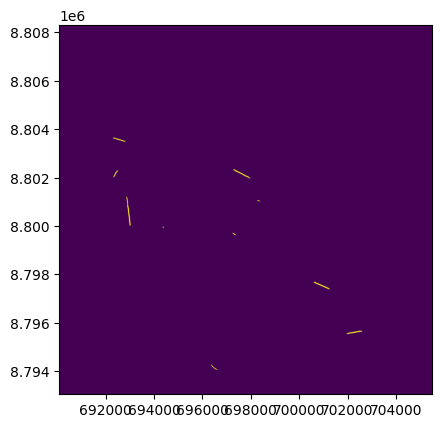

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2020_01_prediction_mosaic.tif
Finished processing AOI: 2020_01
***********************************
Processing AOI: 2021_01
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2021_01_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2350025 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2021_01_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

 22%|██▏       | 257M/1.19G [10:07<36:45, 423kB/s] 


Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2021_01_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2021_01


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

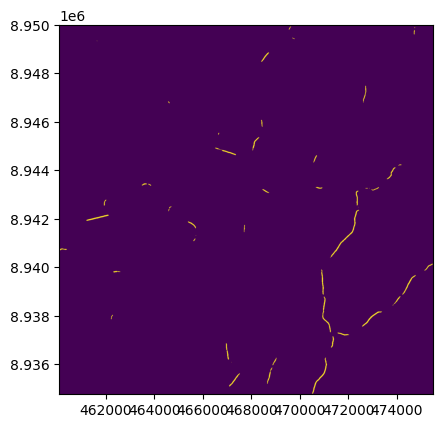

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2021_01_prediction_mosaic.tif
Finished processing AOI: 2021_01
***********************************
Processing AOI: 2023_01
AOI crs: EPSG:32718
New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2023_01_subset.tif
Number of bands in the image: 5
Split image into tiles...


  0%|          | 0/2353107 [00:00<?, ?it/s]

Tiles saved to: /content/working/aoi_2023_01_224x224px_patches.geojson
Make predictions for all image tiles...


  0%|          | 0/49 [00:00<?, ?it/s]

Predictions for all images tiles saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/2023_01_preds_and_padding.geojson
Mosaic all tiles together to create a predction raster...
Predicting pixel values for tiles: 2023_01


Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

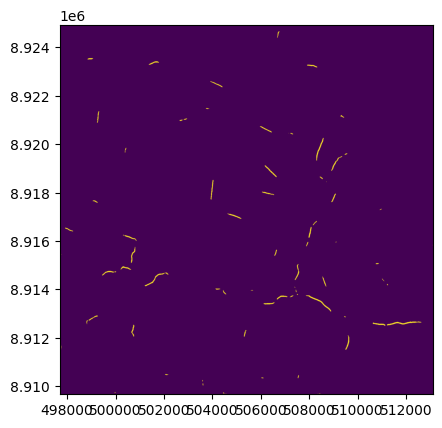

Prediction mosaic saved to: /content/working/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV/aoi_2023_01_prediction_mosaic.tif
Finished processing AOI: 2023_01
***********************************


In [ ]:
for aoi_name in aoi_list:
    print(f"Processing AOI: {aoi_name}")
    aoiboundary, aoicrs = get_aoi_boundary(aoi_name)
    print(f"AOI crs: {aoicrs}")

    # Download inference image
    inference_image_path = get_inference_image(aoi_name, additional_bands=additional_bands)

    # Check image channels
    with rasterio.open(inference_image_path) as src:
        print(f"Number of bands in the image: {src.count}")
        if src.count != model.encoder.conv1.in_channels:
            raise Exception("Number of bands in the image does not match the expected number")

    # Create geojson file of tiles
    print(f"Split image into tiles...")
    output_patch_file = os.path.join(working_path, 'aoi_{}_{}x{}px_patches.geojson'.format(aoi_name, patch_size, patch_size))
    tiles = generate_tiles(inference_image_path, output_patch_file, aoi_name, size=patch_size)

    # Commence model prediction
    print("Make predictions for all image tiles...")
    all_predictions = []  # Store predictions for all tiles
    all_padding = []  # Store predictions for all tiles
    for index in tqdm(range(len(tiles)), total=len(tiles)):
        predictions, padding = predict_airstrip(inference_image_path, [tiles.iloc[index]['geometry']], model, additional_bands)
        all_predictions.append(predictions)
        all_padding.append(padding)

    # Add predictions and padding information to the tiles GeoDataFrame
    tiles["predictions"] = all_predictions
    tiles["padding"] = all_padding

    # Create output directory if it doesn't exist
    output_dir = os.path.join(working_path, model_name)
    os.makedirs(output_dir, exist_ok=True)

    # Save the GeoDataFrame with predictions and padding
    filepath = os.path.join(output_dir, "{}_preds_and_padding.geojson".format(aoi_name))
    tiles.to_file(filepath, driver="GeoJSON")
    print(f"Predictions for all images tiles saved to: {filepath}")

    # Generate a predictions raster
    print("Mosaic all tiles together to create a predction raster...")
    predictions_mosaic = process_and_mosaic_predictions(tiles, inference_image_path, model_name, aoi_name, working_path)

    print(f"Finished processing AOI: {aoi_name}")
    print("***********************************")